## 簡介
- InceptionTime模型為一深度學習時間序列分類模型，透過conv1d截取不同的時間序列patter，類似GoogleNet的概念建立模型。
- 像是CNN類高層layer抓取細緻的pattern, 低層layer抓取粗略的pattern，InceptionTime也是依此原理(因為conv1d)。
- 在深度學習方法算是快速有效率。
- 2018論文

In [37]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the dataset

# 法一
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
train = pd.read_csv(root_url + "FordA_TRAIN.tsv", sep='\t', header=None)
test = pd.read_csv(root_url + "FordA_TEST.tsv", sep='\t', header=None)

x_train, y_train = train.iloc[:, 1:].values, train.iloc[:, 0].values
x_test, y_test = test.iloc[:, 1:].values, test.iloc[:, 0].values

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3601, 500), (3601,), (1320, 500), (1320,))

In [5]:
# reshape

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], -1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], -1)

x_train.shape, x_test.shape

((3601, 500, 1), (1320, 500, 1))

In [6]:
# 其實也可以.fit的時候shuffle=True
# permute

idx = np.random.permutation(len(train))
x_train = x_train[idx]
y_train = y_train[idx]

In [7]:
# label -1 ---> 0

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

np.unique(y_train)

array([0, 1])

### Inception Module
- 最關鍵的Module, 類似GoogleNet的Inception

In [8]:
class InceptionModule(layers.Layer):
    def __init__(self, filters=32, **kwargs):
        super(InceptionModule, self).__init__(**kwargs)

        self.bottleneck = self._default_conv1d(filters, kernel_size=1)
        self.maxpool1d = layers.MaxPool1D(pool_size=3, strides=1, padding='same')
        self.conv1d_1 = self._default_conv1d(filters, kernel_size=10)
        self.conv1d_2 = self._default_conv1d(filters, kernel_size=20)
        self.conv1d_3 = self._default_conv1d(filters, kernel_size=40)
        self.conv1d_4 = self._default_conv1d(filters, kernel_size=1)
        self.concate = layers.Concatenate(axis=2)
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.ReLU()

    def _default_conv1d(self, filters, kernel_size):
        return layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation='relu', use_bias=False)

    def call(self, x):
        bottleneck = self.bottleneck(x)
        conv1d_1 = self.conv1d_1(bottleneck)
        conv1d_2 = self.conv1d_2(bottleneck)
        conv1d_3 = self.conv1d_3(bottleneck)

        maxpool1d = self.maxpool1d(x)
        conv1d_4 = self.conv1d_4(maxpool1d)

        return self.activation(self.batch_norm(self.concate([conv1d_1, conv1d_2, conv1d_3, conv1d_4])))

In [9]:
def get_model_inceptionTime(x, n_module, units=[32, 16], output_units=1):
    inputs = layers.Input(shape=(x.shape[1:]))
    x = inputs

    for i in range(n_module):
        if i % 3 == 2:
            previout_x = x
            x = InceptionModule()(x) + previout_x
        else:
            x = InceptionModule()(x)
    
    outputs = layers.GlobalAveragePooling1D()(x)
    for unit in units:
        outputs = layers.Dense(units=unit, activation='relu')(outputs)
    outputs = layers.Dense(units=output_units, activation='softmax')(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model   

In [28]:
model_1 = get_model_inceptionTime(x_train, 3, [32, 16], 2)
model_2 = get_model_inceptionTime(x_train, 3, [32, 16], 2)
model_3 = get_model_inceptionTime(x_train, 3, [32, 16], 2)
model_4 = get_model_inceptionTime(x_train, 3, [32, 16], 2)
# model.build(input_shape=x.shape)
# model.summary()

In [29]:
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [30]:
# 模型訓練

batch_size = 32
epochs = 200

# 存最好的、lr下降、提早停止
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_1.h5', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]


history_1 = model_1.fit(
    x_train, y_train, batch_size, epochs, validation_split=0.2, verbose=1
)

Epoch 1/200
90/90 [==============================] - 4s 20ms/step - loss: 0.4860 - acc: 0.7347 - val_loss: 0.2912 - val_acc: 0.8641
Epoch 2/200
90/90 [==============================] - 1s 15ms/step - loss: 0.2210 - acc: 0.9115 - val_loss: 0.2688 - val_acc: 0.8877
Epoch 3/200
90/90 [==============================] - 1s 14ms/step - loss: 0.2018 - acc: 0.9191 - val_loss: 0.2513 - val_acc: 0.8932
Epoch 4/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1994 - acc: 0.9208 - val_loss: 0.2165 - val_acc: 0.9182
Epoch 5/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1697 - acc: 0.9330 - val_loss: 0.1889 - val_acc: 0.9154
Epoch 6/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1683 - acc: 0.9358 - val_loss: 0.1938 - val_acc: 0.9293
Epoch 7/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1495 - acc: 0.9378 - val_loss: 0.3322 - val_acc: 0.8793
Epoch 8/200
90/90 [==============================] - 1s 14ms/step - loss: 0.

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_2.h5', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]


history_2 = model_2.fit(
    x_train, y_train, batch_size, epochs, validation_split=0.2, verbose=1
)

Epoch 1/200
90/90 [==============================] - 4s 21ms/step - loss: 0.4178 - acc: 0.7990 - val_loss: 0.2419 - val_acc: 0.9001
Epoch 2/200
90/90 [==============================] - 1s 14ms/step - loss: 0.2203 - acc: 0.9132 - val_loss: 0.2031 - val_acc: 0.9237
Epoch 3/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1894 - acc: 0.9288 - val_loss: 0.1851 - val_acc: 0.9334
Epoch 4/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1887 - acc: 0.9278 - val_loss: 0.1905 - val_acc: 0.9334
Epoch 5/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1722 - acc: 0.9340 - val_loss: 0.1932 - val_acc: 0.9320
Epoch 6/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1797 - acc: 0.9267 - val_loss: 0.1965 - val_acc: 0.9334
Epoch 7/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1845 - acc: 0.9240 - val_loss: 0.2004 - val_acc: 0.9237
Epoch 8/200
90/90 [==============================] - 1s 14ms/step - loss: 0.

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_3.h5', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]


history_3 = model_3.fit(
    x_train, y_train, batch_size, epochs, validation_split=0.2, verbose=1
)

Epoch 1/200
90/90 [==============================] - 3s 20ms/step - loss: 0.4790 - acc: 0.7372 - val_loss: 0.3111 - val_acc: 0.8558
Epoch 2/200
90/90 [==============================] - 1s 14ms/step - loss: 0.2095 - acc: 0.9153 - val_loss: 0.2492 - val_acc: 0.9140
Epoch 3/200
90/90 [==============================] - 1s 14ms/step - loss: 0.2114 - acc: 0.9139 - val_loss: 0.2201 - val_acc: 0.9182
Epoch 4/200
90/90 [==============================] - 1s 15ms/step - loss: 0.1976 - acc: 0.9167 - val_loss: 0.2535 - val_acc: 0.9043
Epoch 5/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1749 - acc: 0.9351 - val_loss: 0.2307 - val_acc: 0.9182
Epoch 6/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1584 - acc: 0.9392 - val_loss: 0.1743 - val_acc: 0.9320
Epoch 7/200
90/90 [==============================] - 1s 15ms/step - loss: 0.1473 - acc: 0.9455 - val_loss: 0.1814 - val_acc: 0.9307
Epoch 8/200
90/90 [==============================] - 1s 14ms/step - loss: 0.

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_4.h5', save_best_only=True, monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=50, verbose=1
    )
]


history_4 = model_4.fit(
    x_train, y_train, batch_size, epochs, validation_split=0.2, verbose=1
)

Epoch 1/200
90/90 [==============================] - 4s 23ms/step - loss: 0.5960 - acc: 0.6410 - val_loss: 0.3052 - val_acc: 0.8696
Epoch 2/200
90/90 [==============================] - 1s 15ms/step - loss: 0.2497 - acc: 0.8993 - val_loss: 0.2162 - val_acc: 0.9154
Epoch 3/200
90/90 [==============================] - 1s 15ms/step - loss: 0.1966 - acc: 0.9229 - val_loss: 0.2001 - val_acc: 0.9265
Epoch 4/200
90/90 [==============================] - 1s 15ms/step - loss: 0.1977 - acc: 0.9222 - val_loss: 0.1873 - val_acc: 0.9293
Epoch 5/200
90/90 [==============================] - 1s 14ms/step - loss: 0.2010 - acc: 0.9167 - val_loss: 0.1965 - val_acc: 0.9307
Epoch 6/200
90/90 [==============================] - 1s 15ms/step - loss: 0.1761 - acc: 0.9302 - val_loss: 0.1927 - val_acc: 0.9279
Epoch 7/200
90/90 [==============================] - 1s 14ms/step - loss: 0.1612 - acc: 0.9375 - val_loss: 0.1945 - val_acc: 0.9279
Epoch 8/200
90/90 [==============================] - 1s 14ms/step - loss: 0.

In [44]:
## load model and  evaluate data

# model_1 = keras.models.load_model('best_model_1.h5')

test_loss, test_acc = model_1.evaluate(x_test, y_test)
print("測試分類正確率: ", test_acc)
print("測試資料loss: ", test_loss)

42/42 [==============================] - 0s 6ms/step - loss: 0.9282 - acc: 0.9455
測試分類正確率:  0.9454545378684998
測試資料loss:  0.9281845688819885


In [45]:
test_loss, test_acc = model_2.evaluate(x_test, y_test)
print("測試分類正確率: ", test_acc)
print("測試資料loss: ", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.7883 - acc: 0.9530
測試分類正確率:  0.9530302882194519
測試資料loss:  0.7883424758911133


In [46]:
test_loss, test_acc = model_3.evaluate(x_test, y_test)
print("測試分類正確率: ", test_acc)
print("測試資料loss: ", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.7422 - acc: 0.9492
測試分類正確率:  0.9492424130439758
測試資料loss:  0.7422130703926086


In [47]:
test_loss, test_acc = model_4.evaluate(x_test, y_test)
print("測試分類正確率: ", test_acc)
print("測試資料loss: ", test_loss)

42/42 [==============================] - 0s 5ms/step - loss: 0.8972 - acc: 0.9455
測試分類正確率:  0.9454545378684998
測試資料loss:  0.8972229957580566


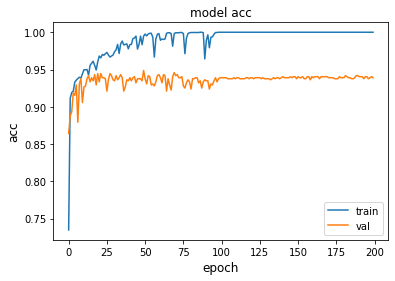

In [38]:
## 觀察訓練的情況, 主要針對效果以及overfitting

plt.figure()
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title("model acc")
plt.ylabel('acc', fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [40]:
## 論文是透過4個emsemble, 因為初始化問題, 在更穩定一些

pred_1 = model_1.predict(x_test)
pred_2 = model_2.predict(x_test)
pred_3 = model_3.predict(x_test)
pred_4 = model_4.predict(x_test)

pred = (pred_1 + pred_2 + pred_3 + pred_4) / 4

values = keras.metrics.sparse_categorical_accuracy(y_test, pred)   # 給出每一個是否預測正確(1: 正確, 0: 不正確)
acc = sum(values) / len(values)
print(acc)

tf.Tensor(0.955303, shape=(), dtype=float32)
